In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy.stats import mannwhitneyu

In [3]:
# Load the CSV files
source_df = pd.read_csv('source_tweets.csv')
reaction_df = pd.read_csv('reaction_tweets.csv')

# Convert 'created_at' to datetime objects
source_df['created_at'] = pd.to_datetime(source_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
reaction_df['created_at'] = pd.to_datetime(reaction_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

In [4]:
# Merge reaction tweets with source tweets based on 'source_tweet_id' and 'tweet_id'
merged_df = pd.merge(
    reaction_df, 
    source_df[['tweet_id', 'created_at']], 
    left_on='source_tweet_id', 
    right_on='tweet_id', 
    suffixes=('_reaction', '_source')
)

# Calculate the time difference between each reaction and its source tweet
merged_df['time_diff_minutes'] = (merged_df['created_at_reaction'] - merged_df['created_at_source']).dt.total_seconds() / 60  # in minutes

# Basic summary statistics for time differences
time_diff_summary = merged_df.groupby('rumor_type')['time_diff_minutes'].describe()

print("Summary of Time Differences (in minutes) between Source and Reaction Tweets:")
print(time_diff_summary)

Summary of Time Differences (in minutes) between Source and Reaction Tweets:
               count        mean          std  min       25%        50%  \
rumor_type                                                                
non-rumours  67952.0  347.719885  1232.667369  0.0  9.966667  39.316667   
rumours      29458.0  210.454142   979.430138  0.0  5.683333  20.033333   

                    75%           max  
rumor_type                             
non-rumours  168.337500  43045.883333  
rumours       72.016667  43725.366667  


In [5]:
# Milestone Analysis - Count number of reactions over time for each source tweet
milestones = [10, 50, 100]
milestone_times = []

for milestone in milestones:
    milestone_df = (
        merged_df.groupby(['source_tweet_id', 'rumor_type'])
        .apply(lambda x: x.nsmallest(milestone, 'time_diff_minutes') if len(x) >= milestone else None)
        .reset_index(drop=True)
    )
    if milestone_df is not None:
        milestone_df = milestone_df.groupby(['source_tweet_id', 'rumor_type']).agg({'time_diff_minutes': 'max'}).reset_index()
        milestone_df['milestone'] = milestone
        milestone_times.append(milestone_df)

milestone_times_df = pd.concat(milestone_times, ignore_index=True)
print("\nMilestone Times for Rumors and Non-Rumors:")
print(milestone_times_df.groupby(['milestone', 'rumor_type'])['time_diff_minutes'].describe())


Milestone Times for Rumors and Non-Rumors:
                        count        mean          std        min        25%  \
milestone rumor_type                                                           
10        non-rumours  2370.0  176.897264   664.481700   0.216667  11.204167   
          rumours      1143.0   90.480709   393.124999   0.883333   7.850000   
50        non-rumours   192.0  862.439583  1640.231387   5.716667  83.341667   
          rumours        49.0  959.000340  2294.397805  23.866667  57.366667   
100       non-rumours    43.0  939.918992  1519.421721  15.383333  71.341667   
          rumours        17.0  737.514706  1879.423929  55.950000  93.083333   

                              50%          75%           max  
milestone rumor_type                                          
10        non-rumours   28.733333    95.904167  13072.400000  
          rumours       17.933333    46.725000   9702.800000  
50        non-rumours  239.775000   968.550000  11726.200000  


In [6]:
# Statistical Test - Mann-Whitney U Test
rumor_times = merged_df[merged_df['rumor_type'] == 'rumours']['time_diff_minutes']
non_rumor_times = merged_df[merged_df['rumor_type'] == 'non-rumours']['time_diff_minutes']
stat, p_value = mannwhitneyu(rumor_times, non_rumor_times)
print(f"\nMann-Whitney U Test Results: U-statistic={stat}, p-value={p_value}")


Mann-Whitney U Test Results: U-statistic=812865645.5, p-value=0.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

# Load the CSV files
source_df = pd.read_csv('source_tweets.csv')
reaction_df = pd.read_csv('reaction_tweets.csv')

# Combine source and reaction tweets for sentiment analysis
all_tweets_df = pd.concat([source_df[['text', 'rumor_type']], reaction_df[['text', 'rumor_type']]], ignore_index=True)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Sentiment Analysis Summary:
            polarity                                                    \
               count      mean       std  min  25%  50%       75%  max   
rumor_type                                                               
non-rumours  71782.0  0.031426  0.302333 -1.0  0.0  0.0  0.136364  1.0   
rumours      31430.0  0.009837  0.289366 -1.0  0.0  0.0  0.093750  1.0   

            subjectivity                                                    \
                   count      mean       std  min  25%       50%       75%   
rumor_type                                                                   
non-rumours      71782.0  0.337531  0.342924  0.0  0.0  0.288889  0.600000   
rumours          31430.0  0.319588  0.339675  0.0  0.0  0.250000  0.577778   

                  
             max  
rumor_type        
non-rumours  1.0  
rumours      1.0  


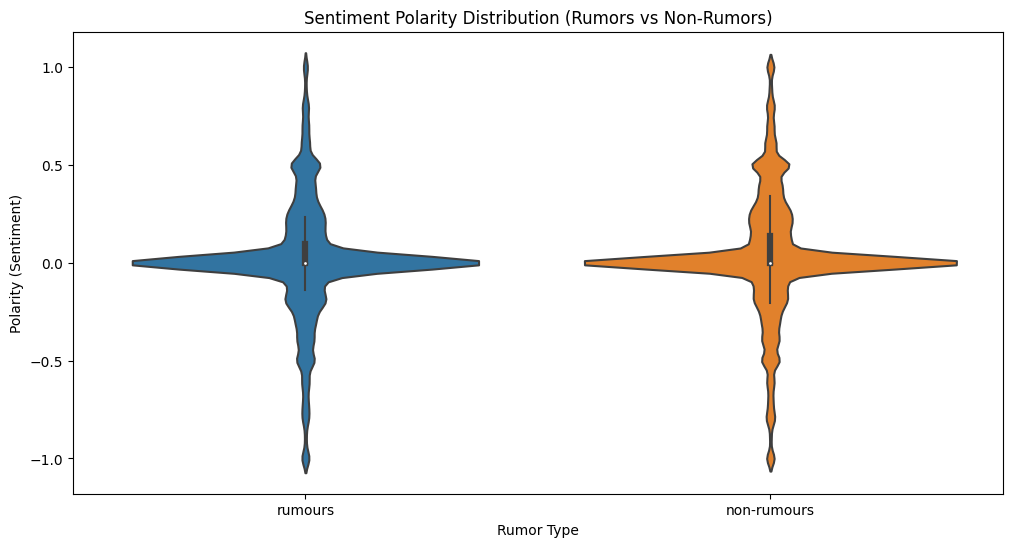

In [8]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis
all_tweets_df['polarity'], all_tweets_df['subjectivity'] = zip(*all_tweets_df['text'].apply(get_sentiment))

# Compare sentiment between rumors and non-rumors
sentiment_summary = all_tweets_df.groupby('rumor_type')[['polarity', 'subjectivity']].describe()
print("Sentiment Analysis Summary:")
print(sentiment_summary)

# Plot sentiment distribution
plt.figure(figsize=(12, 6))
sns.violinplot(data=all_tweets_df, x='rumor_type', y='polarity')
plt.title("Sentiment Polarity Distribution (Rumors vs Non-Rumors)")
plt.xlabel("Rumor Type")
plt.ylabel("Polarity (Sentiment)")
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


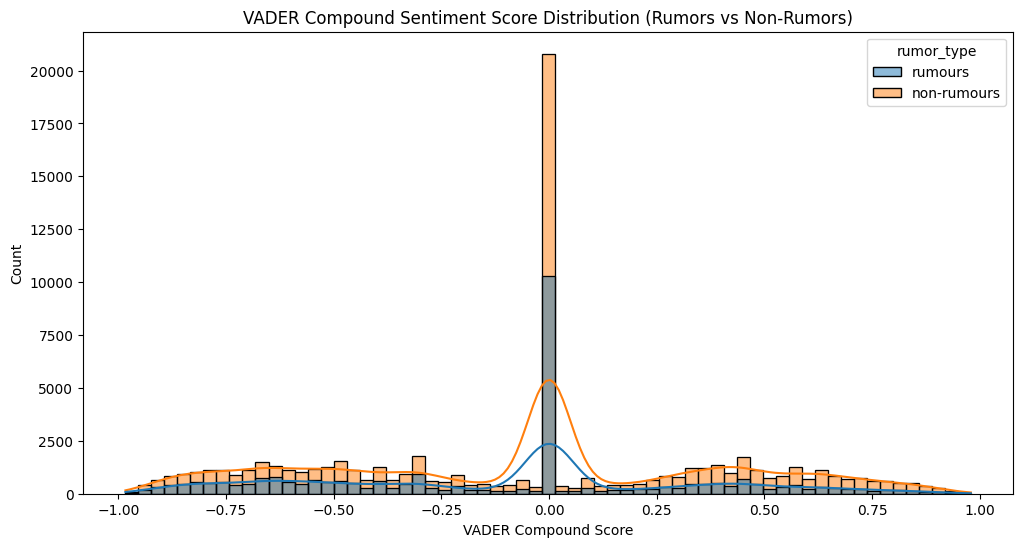

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis
all_tweets_df['vader_scores'] = all_tweets_df['text'].apply(lambda x: sia.polarity_scores(x))

# Extract compound score
all_tweets_df['vader_compound'] = all_tweets_df['vader_scores'].apply(lambda score_dict: score_dict['compound'])

#plot relative frequency of sentiment scores for rumors and non-rumors
plt.figure(figsize=(12, 6))
sns.kdeplot(data=all_tweets_df, x='vader_compound', hue='rumor_type', fill=True, common_norm=False)
plt.title("VADER Compound Sentiment Score Distribution (Rumors vs Non-Rumors)")
plt.xlabel("VADER Compound Score")
plt.show()


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text for topic modeling
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(all_tweets_df['text'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display the top words per topic
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}: ", [feature_names[i] for i in topic.argsort()[-10:]])

Topic 1:  ['ap', 'paris', 'police', 'breaking', 'hostage', 'ottawa', 'sydneysiege', 'hostages', 'sydney', 'http']
Topic 2:  ['foxnews', 'cnnbrk', 'love', 'rt_com', 'skynews', 'don', 'know', 'just', 'people', 'like']
Topic 3:  ['hebdo', 'fuck', 'said', 'independent', 'charlie', 'antoniofrench', 'http', 'thank', 'police', 'ferguson']
Topic 4:  ['happened', 'cnni', 'true', 'attack', 'wsj', 'thanks', 'jesuischarlie', 'https', 'charliehebdo', 'http']
Topic 5:  ['religion', 'germanwings', 'read', 'tweet', 'bbcworld', 'don', 'muslims', 'http', 'islam', 'bbcbreaking']


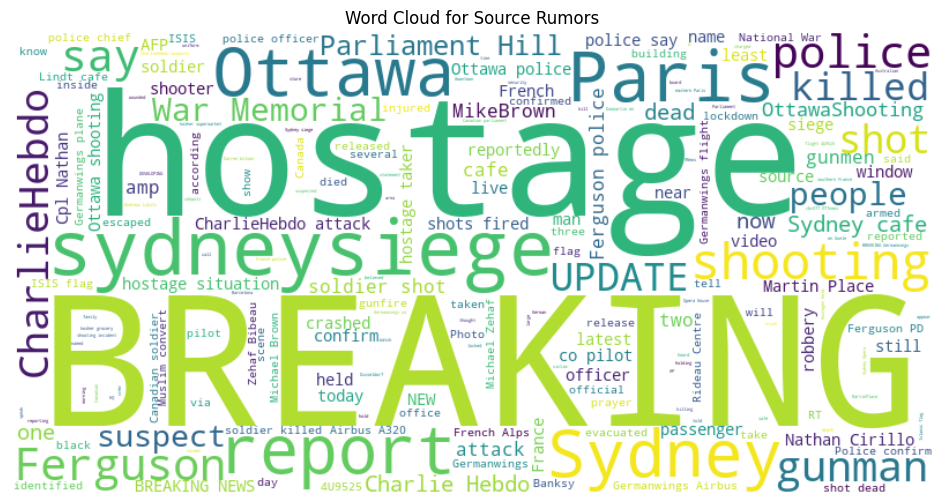

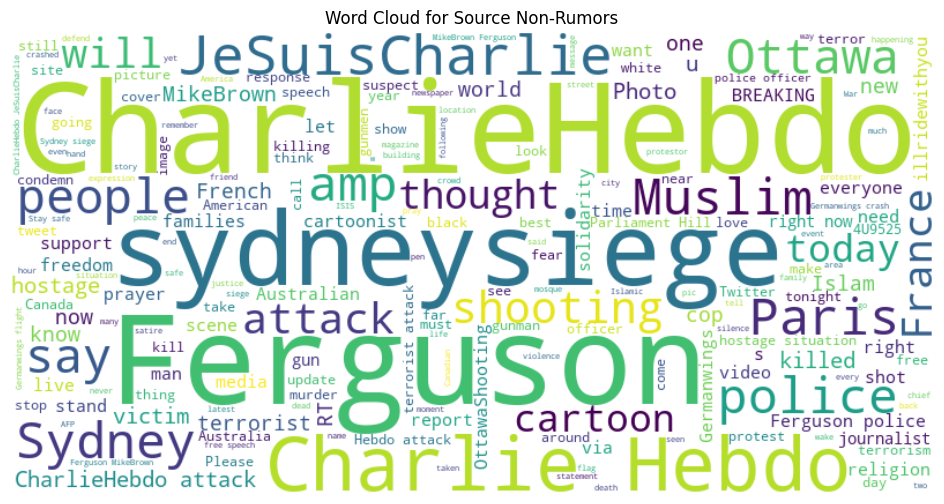

In [21]:
# Generate word clouds
rumor_text = " ".join(source_df[source_df['rumor_type'] == 'rumours']['text'].values)
non_rumor_text = " ".join(source_df[source_df['rumor_type'] == 'non-rumours']['text'].values)

# remove instances of 't co' and 'https' from the text
rumor_text = rumor_text.replace('t.co', '').replace('https', '')
non_rumor_text = non_rumor_text.replace('t.co', '').replace('https', '')

plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(rumor_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Source Rumors")
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(non_rumor_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Source Non-Rumors")
plt.axis('off')
plt.show()

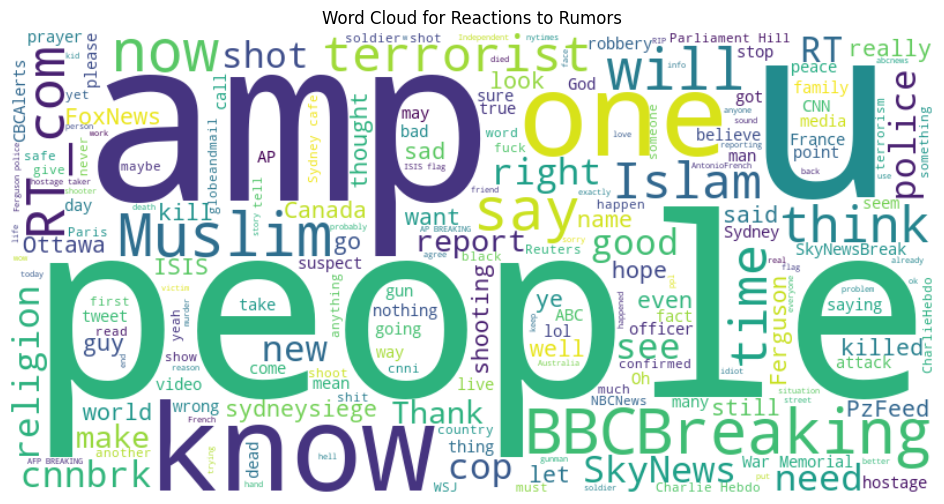

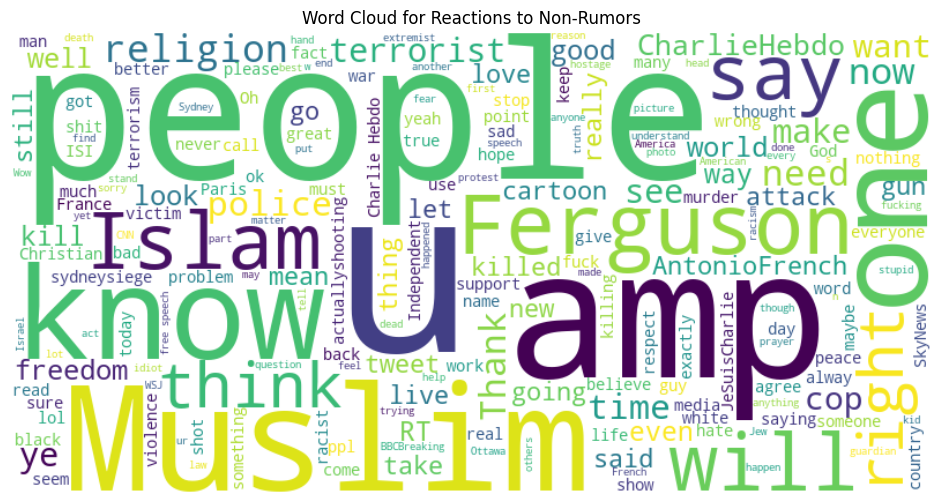

In [20]:
# Generate word clouds
rumor_text = " ".join(reaction_df[reaction_df['rumor_type'] == 'rumours']['text'].values)
non_rumor_text = " ".join(reaction_df[reaction_df['rumor_type'] == 'non-rumours']['text'].values)


rumor_text = rumor_text.replace('t.co', '').replace('https', '')
non_rumor_text = non_rumor_text.replace('t.co', '').replace('https', '')

plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(rumor_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Reactions to Rumors")
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(non_rumor_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Reactions to Non-Rumors")
plt.axis('off')
plt.show()

In [13]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

# Tokenize the text for Word2Vec
all_tweets_df['tokens'] = all_tweets_df['text'].apply(nltk.word_tokenize)

# Train Word2Vec model
w2v_model = Word2Vec(sentences=all_tweets_df['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Find the most similar words to a given term
print("Most similar words to 'attack' in rumor tweets:")
print(w2v_model.wv.most_similar('attack', topn=5))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Most similar words to 'attack' in rumor tweets:
[('attacks', 0.8288577198982239), ('terror', 0.7696017026901245), ('Islamist', 0.7680596113204956), ('Islamic', 0.7635473608970642), ('massacre', 0.7589046359062195)]


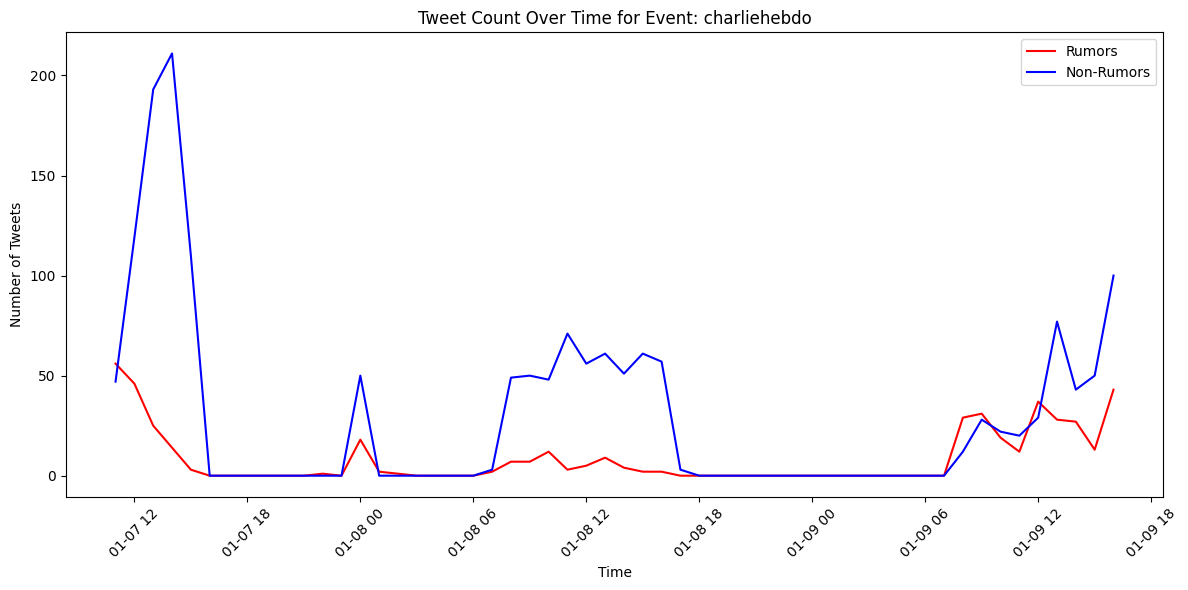

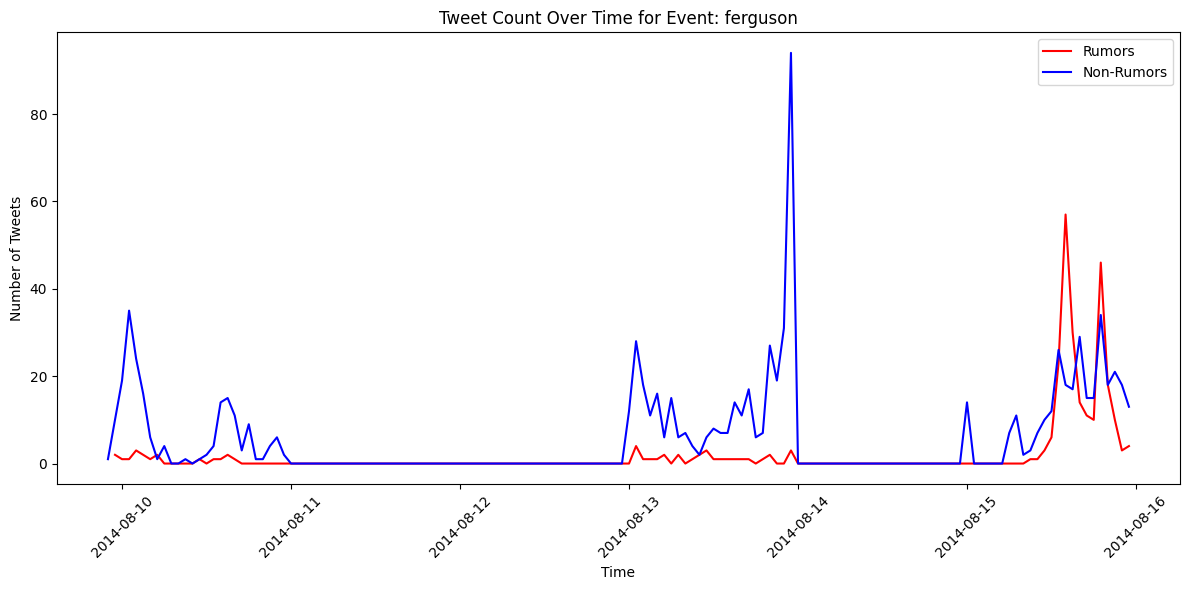

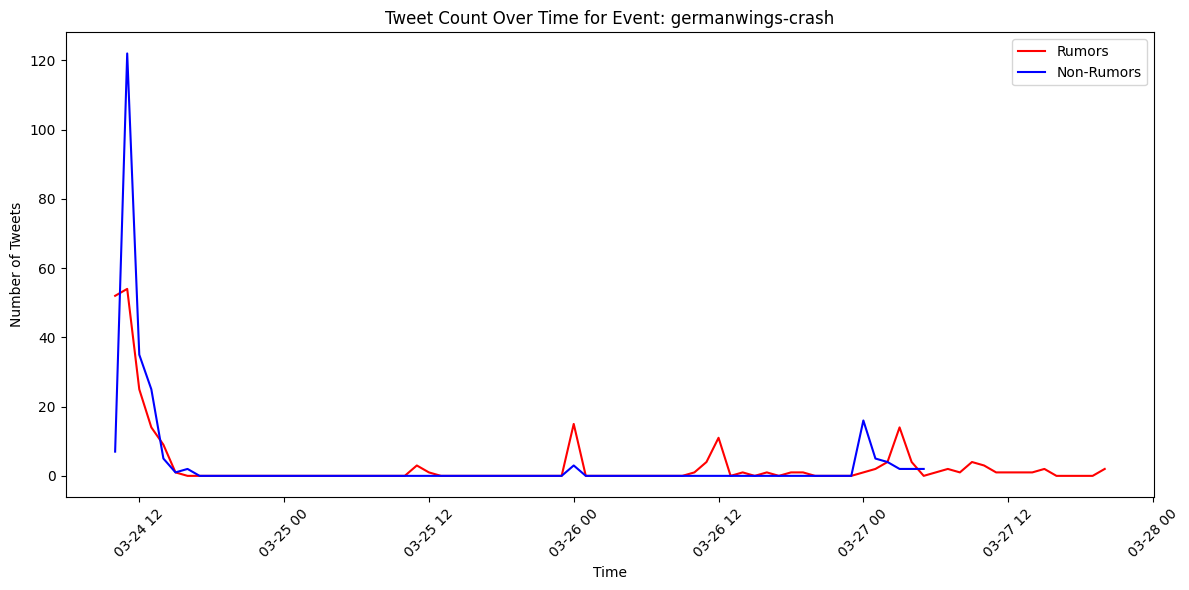

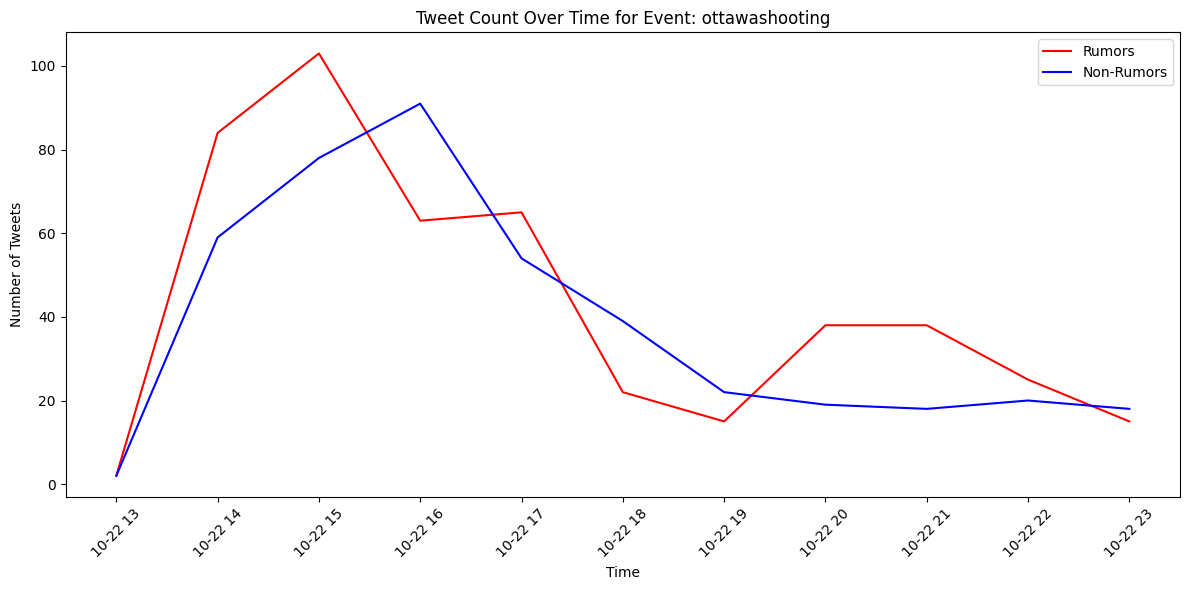

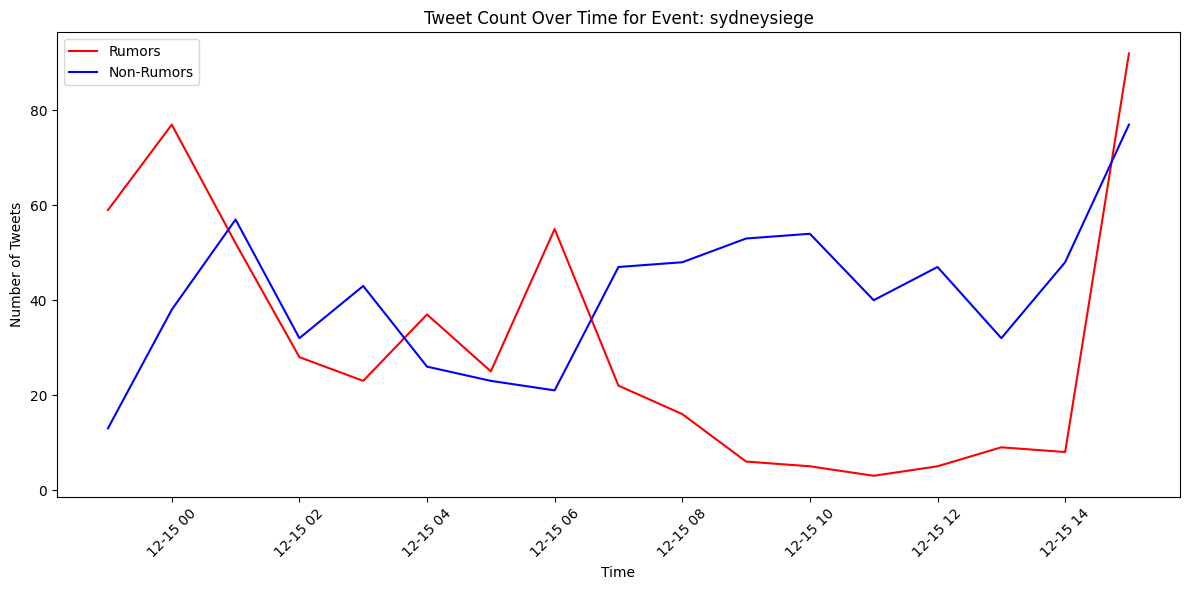

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the source tweets CSV
source_df = pd.read_csv('source_tweets.csv')

# Convert 'created_at' to datetime object for time-based grouping
source_df['created_at'] = pd.to_datetime(source_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

# Group by event and then resample by time intervals (e.g., hourly) to count tweets
# Adjust 'H' for hourly or 'D' for daily
time_interval = 'H'

# Iterate over each unique event in the dataset
for event in source_df['event'].unique():
    event_df = source_df[source_df['event'] == event]
    
    # Separate rumors and non-rumors
    rumor_df = event_df[event_df['rumor_type'] == 'rumours']
    non_rumor_df = event_df[event_df['rumor_type'] == 'non-rumours']
    
    # Resample by the specified time interval to get tweet counts over time
    rumor_counts = rumor_df.set_index('created_at').resample(time_interval).size()
    non_rumor_counts = non_rumor_df.set_index('created_at').resample(time_interval).size()
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(rumor_counts.index, rumor_counts.values, label='Rumors', color='red')
    plt.plot(non_rumor_counts.index, non_rumor_counts.values, label='Non-Rumors', color='blue')
    
    # Customize plot
    plt.title(f"Tweet Count Over Time for Event: {event}")
    plt.xlabel("Time")
    plt.ylabel("Number of Tweets")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show plot
    plt.show()

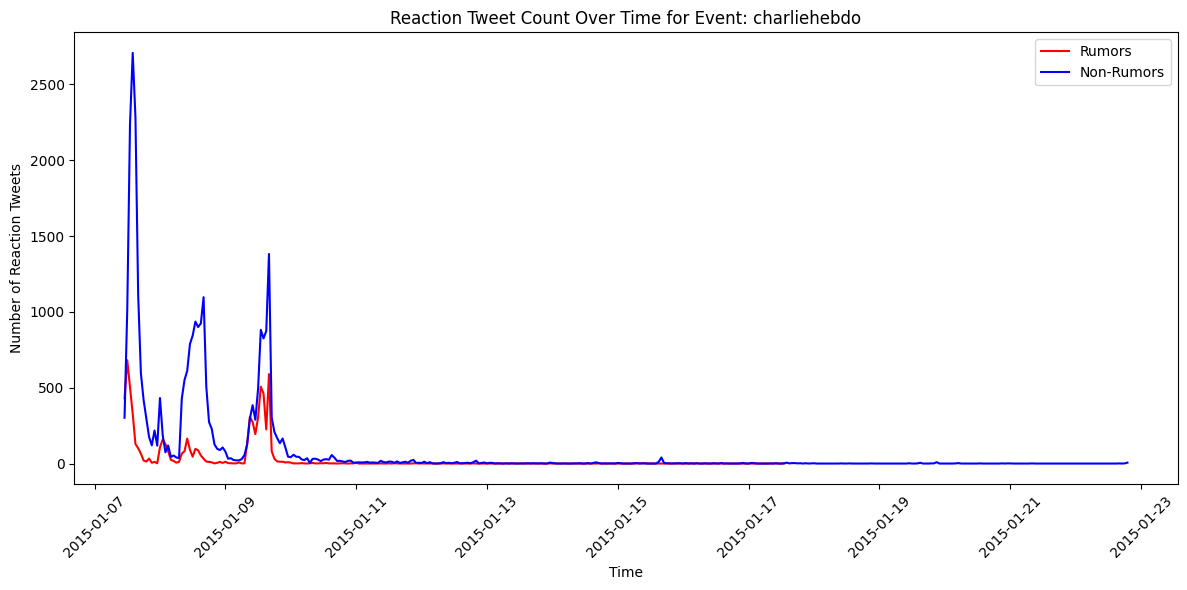

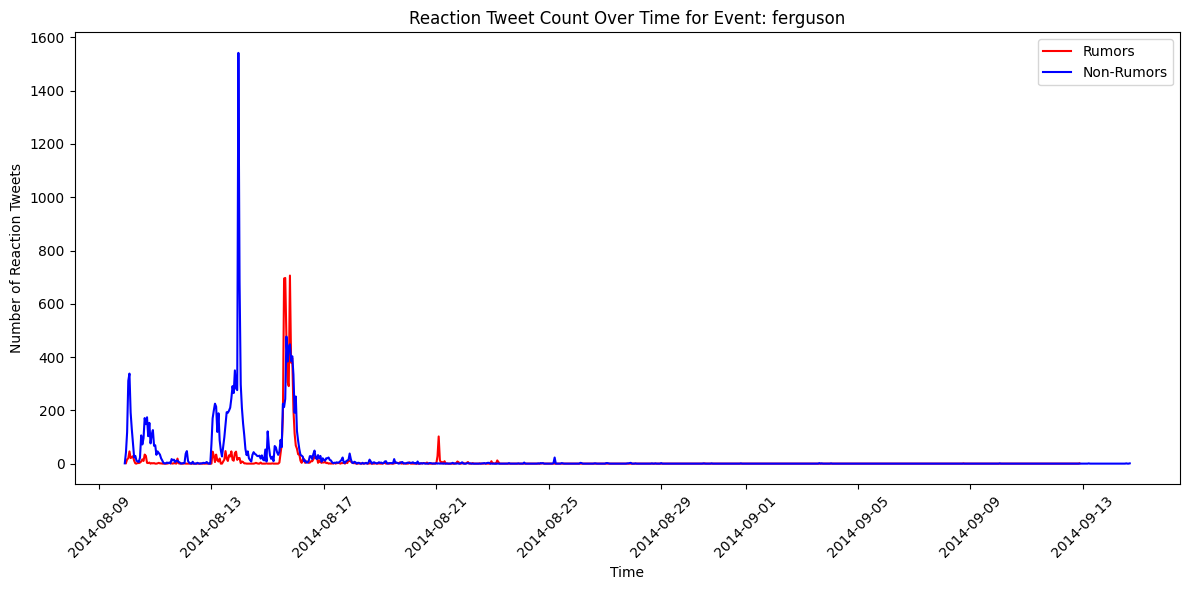

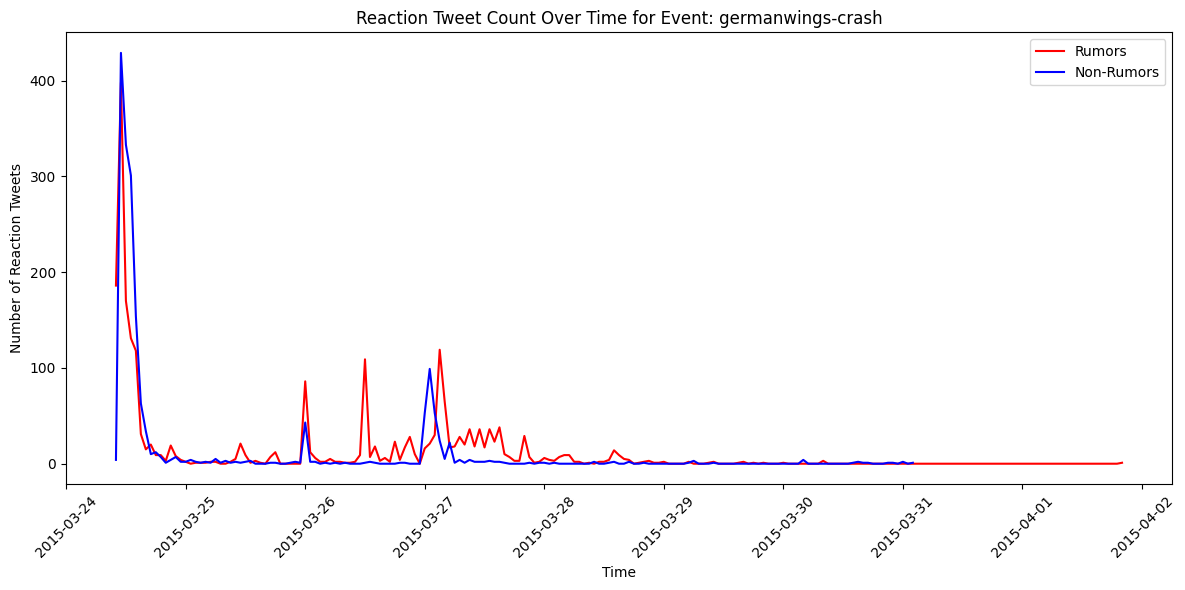

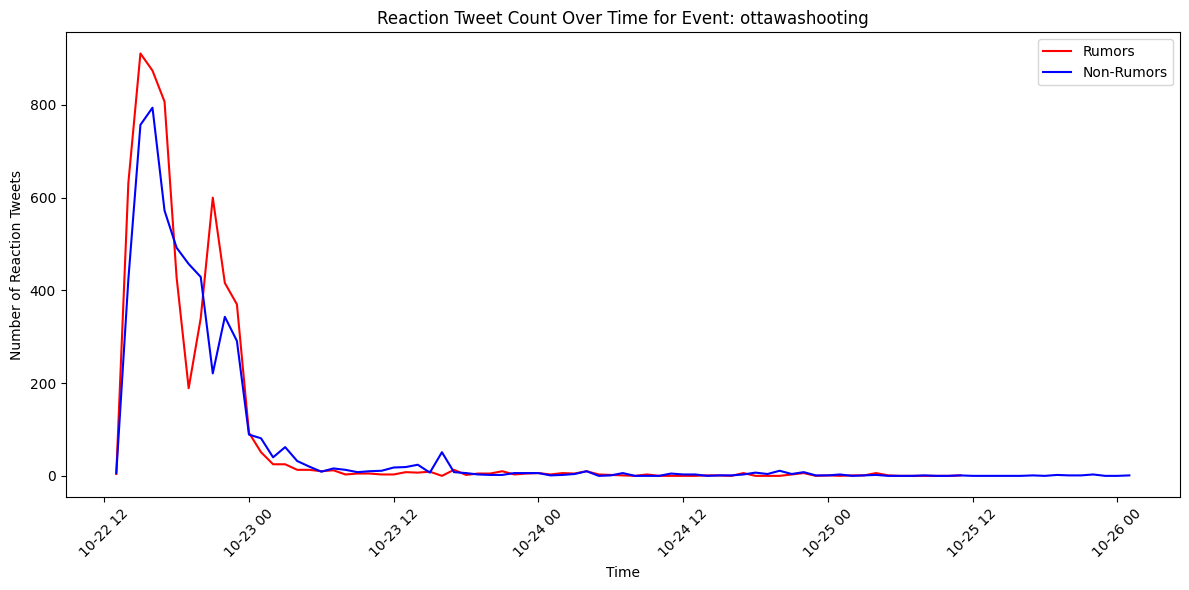

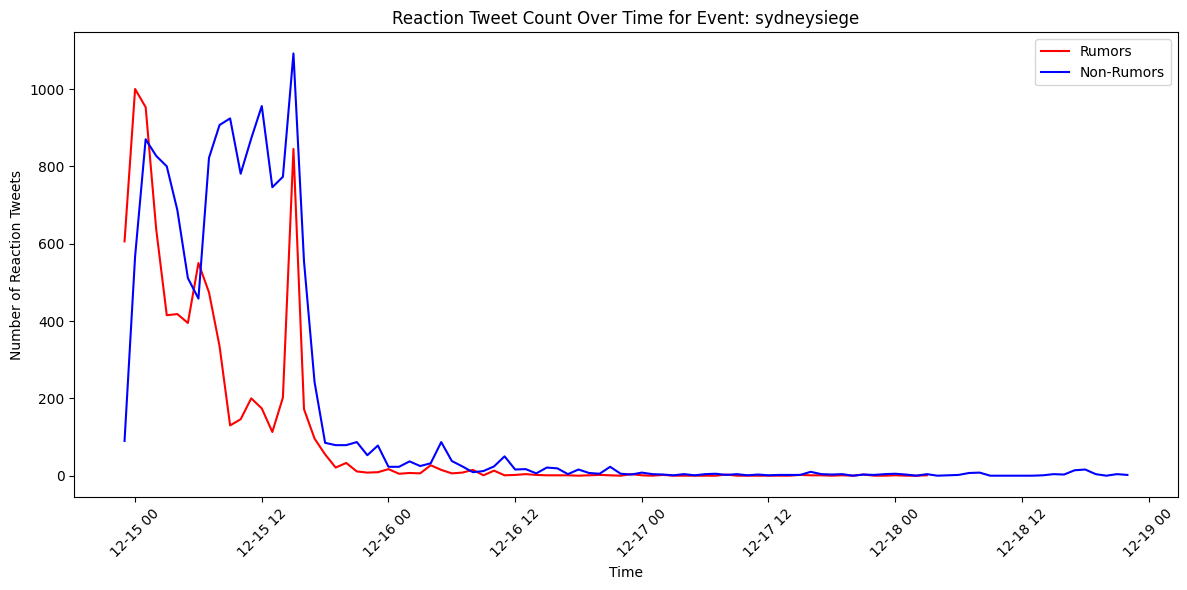

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the reaction tweets CSV
reaction_df = pd.read_csv('reaction_tweets.csv')

# Convert 'created_at' to datetime object for time-based grouping
reaction_df['created_at'] = pd.to_datetime(reaction_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

# Group by event and then resample by time intervals (e.g., hourly) to count tweets
# Adjust 'H' for hourly or 'D' for daily
time_interval = 'H'

# Iterate over each unique event in the dataset
for event in reaction_df['event'].unique():
    event_df = reaction_df[reaction_df['event'] == event]
    
    # Separate rumors and non-rumors
    rumor_df = event_df[event_df['rumor_type'] == 'rumours']
    non_rumor_df = event_df[event_df['rumor_type'] == 'non-rumours']
    
    # Resample by the specified time interval to get tweet counts over time
    rumor_counts = rumor_df.set_index('created_at').resample(time_interval).size()
    non_rumor_counts = non_rumor_df.set_index('created_at').resample(time_interval).size()
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(rumor_counts.index, rumor_counts.values, label='Rumors', color='red')
    plt.plot(non_rumor_counts.index, non_rumor_counts.values, label='Non-Rumors', color='blue')
    
    # Customize plot
    plt.title(f"Reaction Tweet Count Over Time for Event: {event}")
    plt.xlabel("Time")
    plt.ylabel("Number of Reaction Tweets")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show plot
    plt.show()
